In [35]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops

plots_path = 'plots/'

os.makedirs(plots_path, exist_ok=True)

In [2]:
def load_label_map(file_path: str):
    """
    Reads a file with labels and creates a dictionary that maps the name of each image file to its matching number.

    Args:
        file_path (str): The file path to the text
                        (ex: 'labels/LABELS_processed.txt).

    Returns:
        dict: A dictionary where the keys are the filenames (str) and the values are the labels (int)
    """
    labels_maps = {}

    try:
        with open(file_path, 'r') as f:
            for line in f:
                clean_line = line.strip()

                if clean_line:
                    parts = clean_line.split(' ', 1)

                    if len(parts) == 2:
                        label_str, file_name = parts
                        labels_maps[file_name] = int(label_str)

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found")
        return None

    return labels_maps

In [3]:
from typing import Literal

def lbp(image: np.ndarray,
       P : int = 8,
       R : int = 2,
       method : Literal['default', 'ror', 'uniform', 'nri_uniform', 'var'] = 'nri_uniform'):
    assert isinstance(image, np.ndarray) and len(image.shape) == 2
    desc = local_binary_pattern(image, P, R, method=method)

    n_bins = P * ( P - 1) + 3
    hist, _ = np.histogram(desc, density=True, bins=n_bins, range=(0, n_bins))

    return hist


In [27]:
from typing import List, Union

def glcm(image : np.ndarray,
        distances : Union[List[int], np.ndarray] = [1,3,5],
        angles : Union[List[float], np.ndarray]  = np.deg2rad([0,45,90,135])):
    assert isinstance(image, np.ndarray) and len(image.shape) == 2
    hists = graycomatrix(image, distances=distances, angles=angles, normed=True, symmetric=True)
    prop_names = ["contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation"]
    props = np.array([graycoprops(hists, prop).flatten() for prop in prop_names]).flatten()

    return props


In [28]:
from typing import Callable
import os

DescriptorFunction = Callable[[np.ndarray], np.ndarray]

def read_set_file(filepath : str,
                  img_path: str,
                  labels_map : dict,
                  descriptor: DescriptorFunction ) -> tuple[list, list]:
    """
    Uses a filepath that points to a text file where it will use to know which images it has to read, applies a chosen descriptor (LBP, GLCM) 
    and returns the matched features and labels
    Args:
        file_path (str): The file path to the text 
                        (ex: 'labels/train1.txt).
        img_path (str): the base path where the images are located.
        labels_map (dict): a dictionary that have each label mapped to the matching filename.
        descriptor (DescriptorFunction): A function that acts as a descriptor (e.g. LBP or GLCM)
    Returns:
        features and labels
    """
    
    features = []
    labels = []

    with open(filepath, 'r') as f:
        for file_name in f:
            file_name = file_name.strip()
            class_name = file_name.split('_')[0]

            full_path = os.path.join(img_path, class_name, file_name)
            gray_img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)

            if gray_img is not None:
                features_vector = descriptor(gray_img)
                features.append(features_vector)
                labels.append(labels_map[file_name])

    return features, labels

In [29]:
from functools import partial
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

lbp_param_grid = [
    {'P': 8, 'R': 1},
    {'P': 24, 'R': 3},
]

glcm_param_grid = [
    {'distances': [1, 3, 5]},
    {'distances': [7, 9, 11]}
]

svc_param_grid = [
    {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'},
    {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'},
    {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'},
    {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},

    {'C': 1, 'kernel': 'linear'},
    {'C': 10, 'kernel': 'linear'},
]

knn_param_grid = [
    {'n_neighbors': 5, 'metric': 'euclidean', 'n_jobs': -1},
    {'n_neighbors': 5, 'metric': 'manhattan',  'n_jobs': -1},
    {'n_neighbors': 11, 'metric': 'euclidean',  'n_jobs': -1},
    {'n_neighbors': 11, 'metric': 'manhattan',  'n_jobs': -1},
]

labels_map = load_label_map('FMD/LABELS_processed.txt')
images_base_path = 'FMD/images/'

descriptors_to_test = [
    ('LBP', partial(lbp), lbp_param_grid),
    ('GLCM', partial(glcm), glcm_param_grid)
]

classifiers_to_test = [
    ('SVM', SVC, svc_param_grid),
    ('k-NN', KNeighborsClassifier, knn_param_grid)
]

all_experimental_results = []

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

for desc_name, desc_func, desc_param_grid in descriptors_to_test:

    for desc_params in desc_param_grid: 
        print(f"\n==== EXTRACTOR: {desc_name} ({desc_params}) ====")

        all_folds_features = []
        all_folds_labels = []

        current_desc = partial(desc_func, **desc_params)
        pre_extracted_folds_data = []
        
        for i in range(1,11):
            train_features, train_labels = read_set_file(
                f'FMD/labels/train{i}.txt', images_base_path, labels_map, current_desc
            )
            test_features, test_labels = read_set_file(
                f'FMD/labels/test{i}.txt', images_base_path, labels_map, current_desc
            )
            pre_extracted_folds_data.append({
                    'X_train': np.array(train_features), 'y_train': np.array(train_labels),
                    'X_test': np.array(test_features), 'y_test': np.array(test_labels)
               })
               



        print("Starting classifiers test...")

        for clf_name, clf_class, clf_param_grid in classifiers_to_test:
    
            for clf_params in clf_param_grid:

                fold_reports = []
                fold_confusion_matrices = []

                for fold_data in pre_extracted_folds_data:
                    
                    X_train, y_train = fold_data['X_train'], fold_data['y_train']
                    X_test, y_test = fold_data['X_test'], fold_data['y_test']

                    scaler = StandardScaler()

                    X_train_normalized = scaler.fit_transform(X_train)
                    X_test_normalized = scaler.transform(X_test)

                    model = clf_class(**clf_params)
                    model.fit(X_train_normalized, y_train)
                    y_pred = model.predict(X_test_normalized)

                    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
                    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
                    fold_reports.append(report)
                    fold_confusion_matrices.append(cm)

                avg_accuracy = np.mean([r['accuracy'] for r in fold_reports])
                std_accuracy = np.std([r['accuracy'] for r in fold_reports])

                num_classes = fold_confusion_matrices[0].shape[0]
                sum_cm = np.zeros((num_classes, num_classes), dtype=int)
                for cm in fold_confusion_matrices:
                    if cm.shape == sum_cm.shape:
                        sum_cm += cm

                result = {
                    'descriptor': desc_name,
                    'descriptor_params': str(desc_params),
                    'classifier': clf_name,
                    'classifier_params': str(clf_params),
                    'avg_accuracy': avg_accuracy,
                    'std_accuracy': std_accuracy,
                    'summed_confusion_matrix': sum_cm
                }
                all_experimental_results.append(result)
                print(f"Result: Mean Accuracy = {avg_accuracy:.4f} (+/- {std_accuracy:.4f})")




==== EXTRACTOR: LBP ({'P': 8, 'R': 1}) ====
Starting classifiers test...
Result: Mean Accuracy = 0.3250 (+/- 0.0356)
Result: Mean Accuracy = 0.3820 (+/- 0.0387)
Result: Mean Accuracy = 0.3330 (+/- 0.0438)
Result: Mean Accuracy = 0.4000 (+/- 0.0332)
Result: Mean Accuracy = 0.3980 (+/- 0.0458)
Result: Mean Accuracy = 0.3600 (+/- 0.0463)
Result: Mean Accuracy = 0.3190 (+/- 0.0308)
Result: Mean Accuracy = 0.3190 (+/- 0.0345)
Result: Mean Accuracy = 0.3130 (+/- 0.0369)
Result: Mean Accuracy = 0.3190 (+/- 0.0327)

==== EXTRACTOR: LBP ({'P': 24, 'R': 3}) ====
Starting classifiers test...
Result: Mean Accuracy = 0.1490 (+/- 0.0192)
Result: Mean Accuracy = 0.3110 (+/- 0.0259)
Result: Mean Accuracy = 0.1600 (+/- 0.0200)
Result: Mean Accuracy = 0.3180 (+/- 0.0374)
Result: Mean Accuracy = 0.4050 (+/- 0.0367)
Result: Mean Accuracy = 0.4050 (+/- 0.0367)
Result: Mean Accuracy = 0.2890 (+/- 0.0339)
Result: Mean Accuracy = 0.2950 (+/- 0.0385)
Result: Mean Accuracy = 0.2930 (+/- 0.0272)
Result: Mean Ac

KeyError: 'descriptor'



--- Final Result Analysis ---

==== Best Results by Combination ====
   descriptor          descriptor_params classifier  \
14        LBP          {'P': 24, 'R': 3}        SVM   
25       GLCM   {'distances': [1, 3, 5]}        SVM   
6         LBP           {'P': 8, 'R': 1}       k-NN   
39       GLCM  {'distances': [7, 9, 11]}       k-NN   

                                    classifier_params  avg_accuracy  \
14                       {'C': 1, 'kernel': 'linear'}         0.405   
25                      {'C': 10, 'kernel': 'linear'}         0.339   
6   {'n_neighbors': 5, 'metric': 'euclidean', 'n_j...         0.319   
39  {'n_neighbors': 11, 'metric': 'manhattan', 'n_...         0.225   

    std_accuracy                            summed_confusion_matrix  
14      0.036674  [[30, 24, 11, 10, 3, 1, 6, 10, 5, 0], [19, 46,...  
25      0.036180  [[25, 20, 7, 7, 6, 5, 6, 13, 8, 3], [19, 37, 4...  
6       0.030806  [[33, 24, 9, 7, 6, 1, 3, 11, 1, 5], [17, 45, 9...  
39      0.039306 

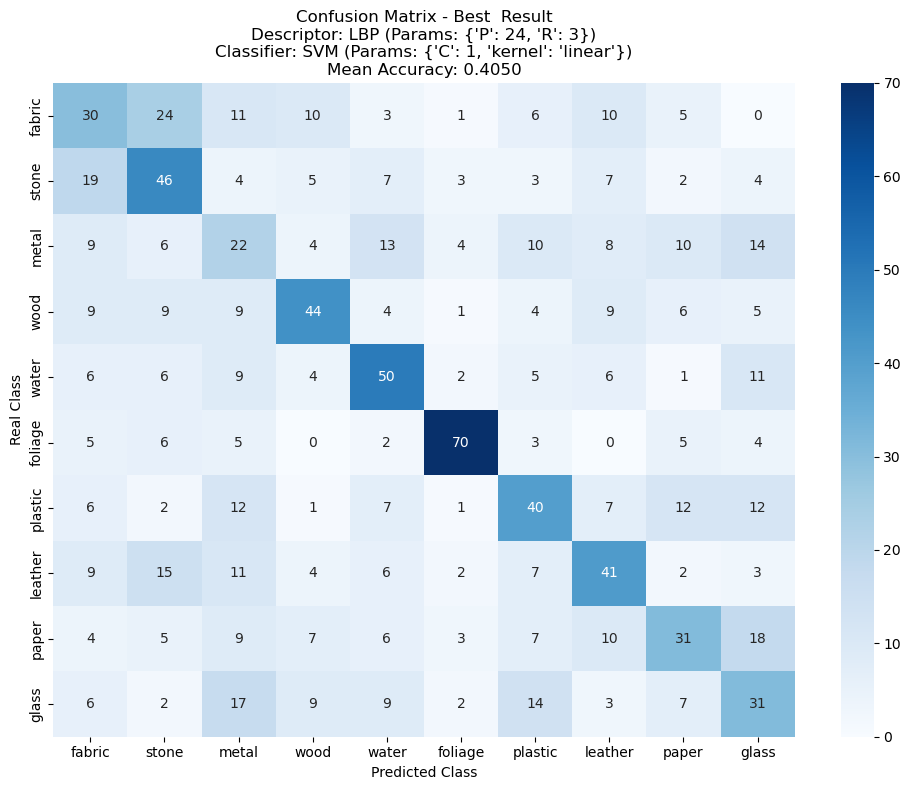

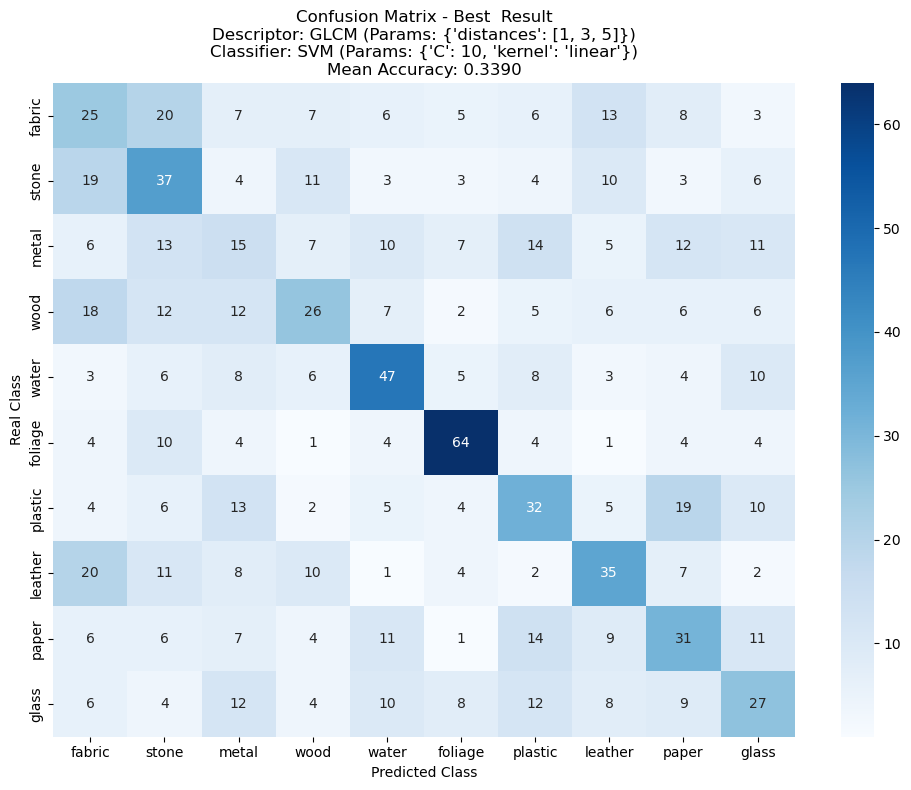

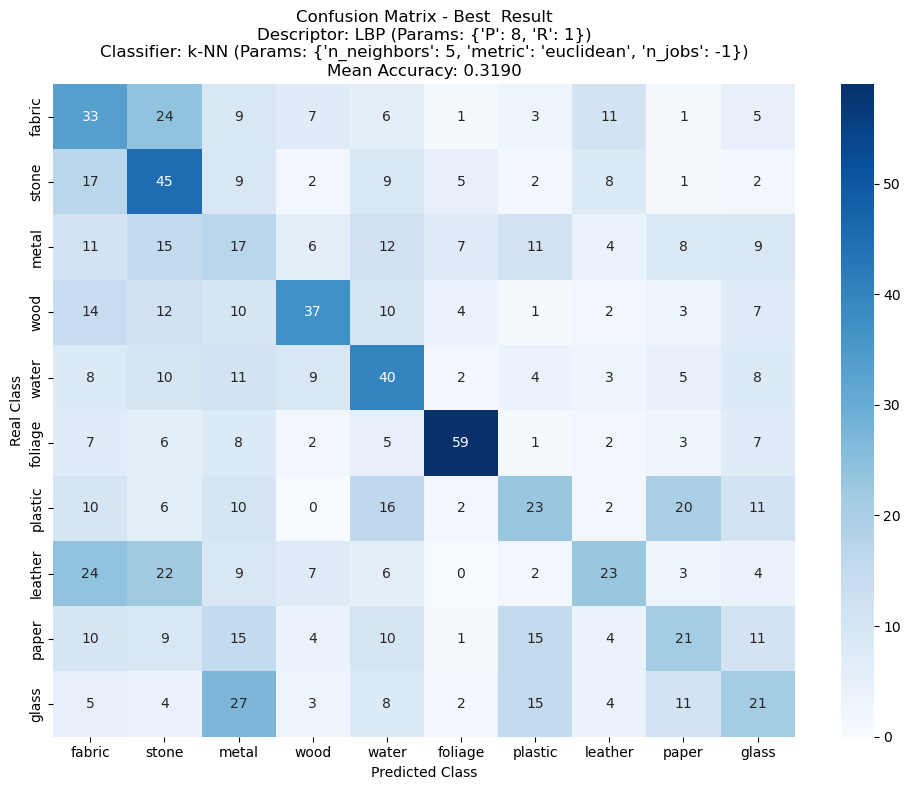

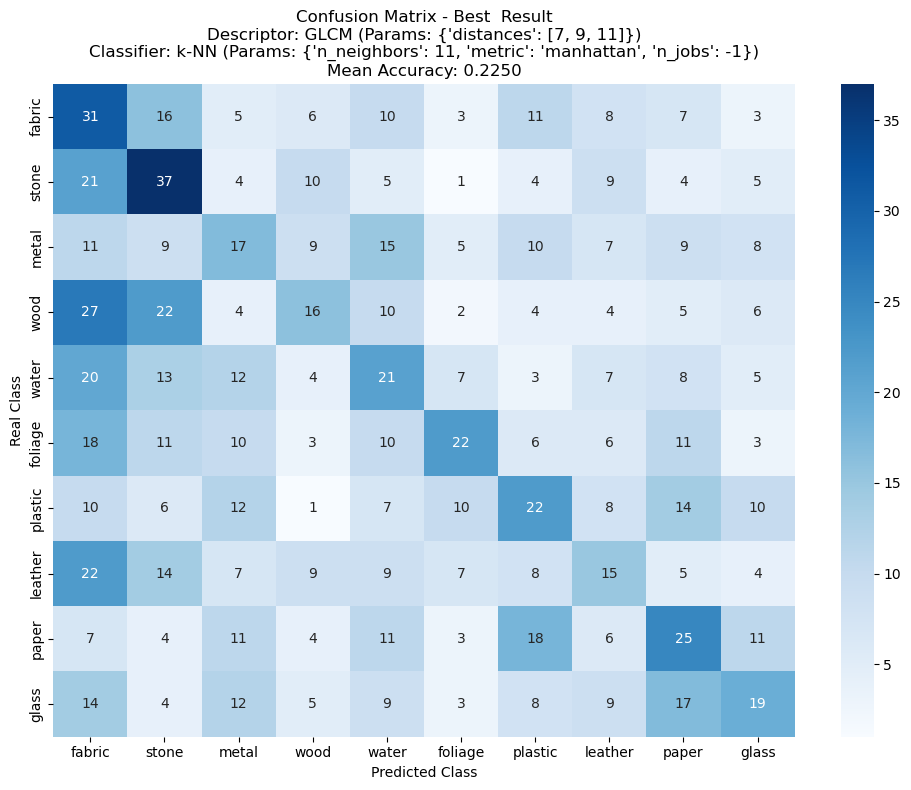

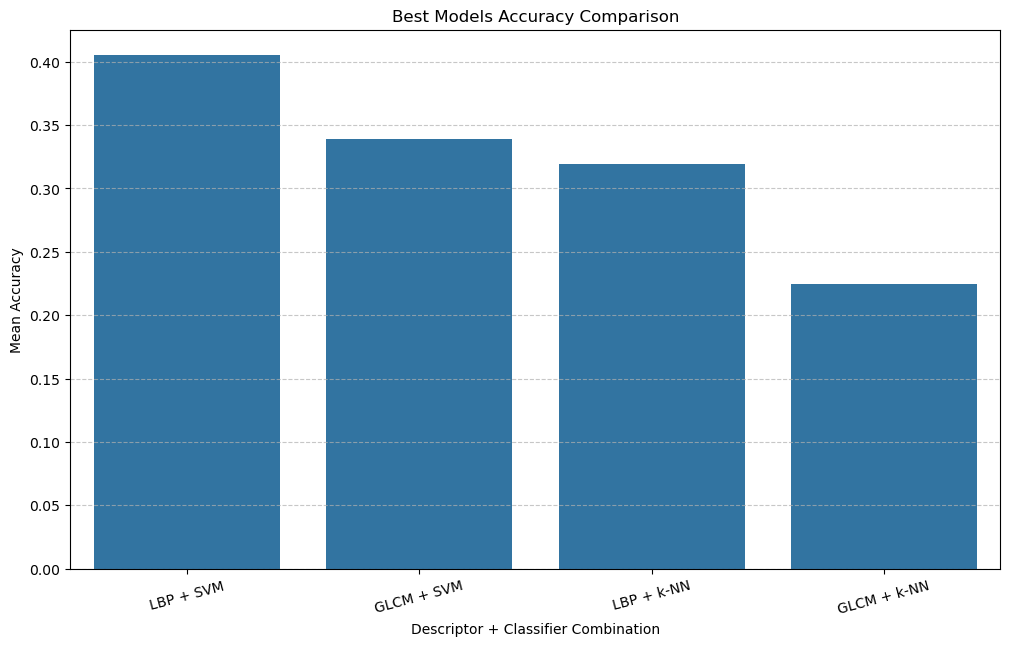

In [36]:
print("\n\n--- Final Result Analysis ---")

df_results = pd.DataFrame(all_experimental_results)

best_indices = df_results.groupby(['descriptor', 'classifier'])['avg_accuracy'].idxmax()
best_results_per_combination = df_results.loc[best_indices]

best_results_per_combination = best_results_per_combination.sort_values(by='avg_accuracy', ascending=False)

print("\n==== Best Results by Combination ====")
print(best_results_per_combination)

class_names = ['fabric', 'stone', 'metal', 'wood', 'water', 
               'foliage', 'plastic', 'leather', 'paper', 'glass']

for index, row in best_results_per_combination.iterrows():
    plt.figure(figsize=(10, 8))
    sns.heatmap(row['summed_confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    title = (f"Confusion Matrix - Best  Result\n"
            f"Descriptor: {row['descriptor']} (Params: {row['descriptor_params']})\n"
            f"Classifier: {row['classifier']} (Params: {row['classifier_params']})\n"
            f"Mean Accuracy: {row['avg_accuracy']:.4f}")

    plt.title(title)
    plt.ylabel('Real Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_path, f"{row['classifier']}_{row['descriptor']}_cm"))
    plt.show()

plt.figure(figsize=(12, 7))
best_results_per_combination['model_combination'] = best_results_per_combination['descriptor'] + ' + ' + best_results_per_combination['classifier']
sns.barplot(data=best_results_per_combination, x='model_combination', y='avg_accuracy')
plt.title('Best Models Accuracy Comparison')
plt.ylabel('Mean Accuracy')
plt.xlabel('Descriptor + Classifier Combination')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(plots_path, f"{row['classifier']}_{row['descriptor']}_bar"))
plt.show()


In [44]:
import ast

print("\n\n==== Detailed Classification Reports (Rerunning the bestests) ====")

for index, row in best_results_per_combination.iterrows():

    desc_name = row['descriptor']
    desc_params = ast.literal_eval(row['descriptor_params'])

    clf_name = row['classifier']
    clf_params = ast.literal_eval(row['classifier_params'])

    print("\n-------------------------------------------------------------------------")
    print(f"### Rerunning for: {desc_name} + {clf_name}")
    print(f"### Params: {desc_params} -> {clf_params}")
    print("\n-------------------------------------------------------------------------")

    desc_func = [d[1] for d in descriptors_to_test if d[0] == desc_name][0]
    current_desc = partial(desc_func, **desc_params)

    clf_class = [c[1] for c in classifiers_to_test if c[0] == clf_name][0]

    fold_reports = []

    for i in range (1, 11):
        train_features, train_labels = read_set_file(f'FMD/labels/train{i}.txt', images_base_path, labels_map, current_desc)
        test_features, test_labels = read_set_file(f'FMD/labels/test{i}.txt', images_base_path, labels_map, current_desc)

        X_train, y_train = np.array(train_features), np.array(train_labels)
        X_test, y_test = np.array(test_features), np.array(test_labels)

        scaler = StandardScaler()
        X_train_normalized = scaler.fit_transform(X_train)
        X_test_normalized = scaler.transform(X_test)

        model = clf_class(**clf_params)
        model.fit(X_train_normalized, y_train)
        y_pred = model.predict(X_test_normalized)

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        fold_reports.append(report)
        
    class_keys = [k for k in fold_reports[0].keys() if k not in ['accuracy']]
    avg_report = {}

    for key in class_keys:
        p = np.mean([fold[key]['precision'] for fold in fold_reports])
        r = np.mean([fold[key]['recall'] for fold in fold_reports])
        f1 = np.mean([fold[key]['f1-score'] for fold in fold_reports])
        s = np.mean([fold[key]['support'] for fold in fold_reports])
        avg_report[key] = {'precision': p, 'recall': r,  'f1-score': f1, 'support': s}


    print(f"{'Class':<15} {'precision':>12} {'recall':>12} {'f1-score':>12} {'support':>12}")
    print("-" * 65)

    for class_name_index, values in avg_report.items():
        try:
            class_label = class_names[int(class_name_index) - 1]
        except (ValueError, IndexError):
            class_label = class_name_index
        if class_label in ['macro avg', 'weighted avg']:
            print("-" * 65)

        print(f"{class_label:<15}"
             f"{values['precision']:>12.2f}"
             f"{values['recall']:>12.2f}"
             f"{values['f1-score']:>12.2f}"
             f"{values['support']:>12.0f}")
print("\n-----------------------------------------------------------------------------")



==== Detailed Classification Reports (Rerunning the bestests) ====

-------------------------------------------------------------------------
### Rerunning for: LBP + SVM
### Params: {'P': 24, 'R': 3} -> {'C': 1, 'kernel': 'linear'}

-------------------------------------------------------------------------
Class              precision       recall     f1-score      support
-----------------------------------------------------------------
fabric                 0.30        0.30        0.29          10
stone                  0.39        0.46        0.41          10
metal                  0.20        0.22        0.20          10
wood                   0.50        0.44        0.46          10
water                  0.48        0.50        0.48          10
foliage                0.80        0.70        0.74          10
plastic                0.41        0.40        0.40          10
leather                0.43        0.41        0.41          10
paper                  0.39        0.31     